In [191]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import cv2
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelBinarizer

In [192]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def normalize_greyscale(X):
    a,b,xmin,xmax = 0.1,0.9,0,255
    return a+(X-xmin)*(b-a)/(xmax-xmin)

def grayscale_4d(X):
    X_gray = np.empty(X[:,:,:,0].shape)
    for i in range(len(X_gray)):
        X_gray[i] = normalize_greyscale(grayscale(X[i]))
    return(X_gray)

def flat_3d(X):
    n, a,b = X.shape[0],X.shape[1],X.shape[2]
    X_flat = np.empty((n,a*b))
    for i in range(len(X_flat)):
        X_flat[i] = X[i].reshape(a*b)
    return(X_flat)

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [193]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train_cls = train['features'], train['labels']
X_test, y_test_cls = test['features'], test['labels']

X_train = grayscale_4d(X_train)
X_test = grayscale_4d(X_test)

X_train = flat_3d(X_train)
X_test = flat_3d(X_test)

X_train,y_train_cls = shuffle_in_unison(X_train, y_train_cls)

In [194]:
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = len(Counter(y_train_cls)) #43

In [195]:
encoder = LabelBinarizer()
encoder.fit(y_train_cls)
y_train = encoder.transform(y_train_cls).astype(np.float32)
y_test = encoder.transform(y_test_cls).astype(np.float32)

In [196]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

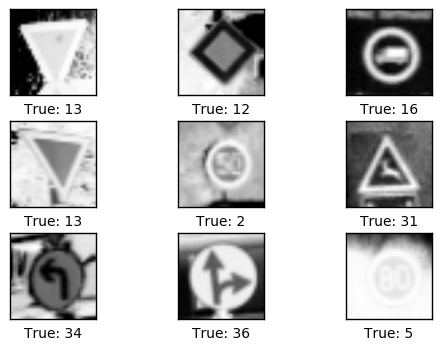

In [197]:
# Get the first images from the test-set.
images = X_train[0:9]

# Get the true classes for those images.
cls_true = y_train_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helpers

In [198]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [199]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [200]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholders

In [201]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to optimize

In [202]:
# weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
# biases = tf.Variable(tf.zeros([num_classes]))

### Model

In [236]:
logits = tf.matmul(x, weights) + biases
layer = tf.nn.relu(logits)
print(type(num_classes))
# layer = new_fc_layer(x,          # The previous layer.
#                  img_size_flat,     # Num. inputs from prev. layer.
#                  num_classes,    # Num. outputs.
#                  use_relu=True) # Use Rectified Linear Unit (ReLU)?
    
y_pred = tf.nn.softmax(layer)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

<class 'int'>


### Optimizer

In [237]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Measuring performance

In [238]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Run

In [239]:
session = tf.Session()
session.run(tf.initialize_all_variables())

In [240]:
batch_size = 1024

In [241]:
def optimize(num_iterations):
    for i in range(num_iterations):
        
        batch_start = i*batch_size % len(X_train)
        batch_end = min(batch_start+batch_size,len(X_train))
        x_batch = X_train[batch_start:batch_end]
        y_true_batch = y_train[batch_start:batch_end]
        y_true_batch_cls = y_train_cls[batch_start:batch_end]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        _, batch_cost = session.run([optimizer, cost], feed_dict=feed_dict_train)
        
        # Print status every 100 iterations.
#         if i % 100 == 0:
#             feed_dict_train_accuracy = {x: x_batch, y_true: y_true_batch, y_true_cls: y_true_batch_cls}
#             acc = session.run(accuracy, feed_dict=feed_dict_train_accuracy)
#             msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Batch Cost: {2}"
#             print(msg.format(i + 1, acc, batch_cost))

### Helper-functions to show performance

In [242]:
feed_dict_test = {x: X_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls}

In [243]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [244]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [245]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [246]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(5, 10)
    fig.subplots_adjust(hspace=1, wspace=1)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<num_classes:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("W: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization 

In [247]:
print_accuracy()

Accuracy on test-set: 0.5%


## Performance after 1 optimization iteration

Accuracy on test-set: 7.6%


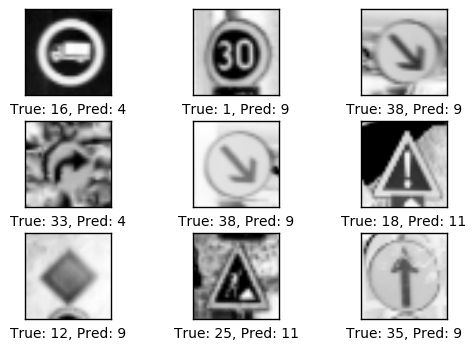

In [250]:
optimize(num_iterations=1)
print_accuracy()
plot_example_errors()

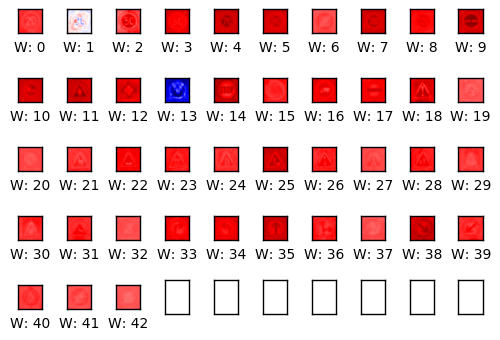

In [251]:
plot_weights()

In [ ]:
print_confusion_matrix()

## Performance after 10 optimization iteration

In [ ]:
optimize(num_iterations=9)
print_accuracy()

In [ ]:
plot_example_errors()

In [ ]:
plot_weights()

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


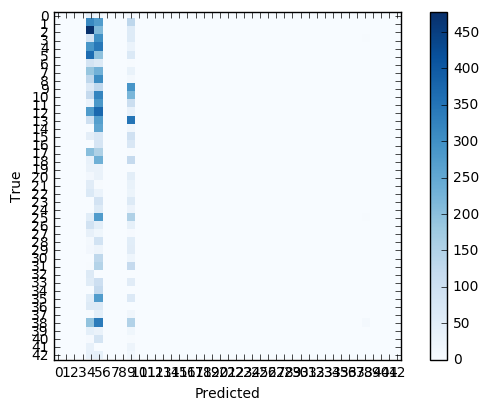

In [127]:
print_confusion_matrix()

## Performance after 100 optimization iterations

In [178]:
optimize(num_iterations=90)

Optimization Iteration:      1, Training Accuracy:  18.0%, Batch Cost: 4.4773688316345215


In [179]:
print_accuracy()

Accuracy on test-set: 22.6%


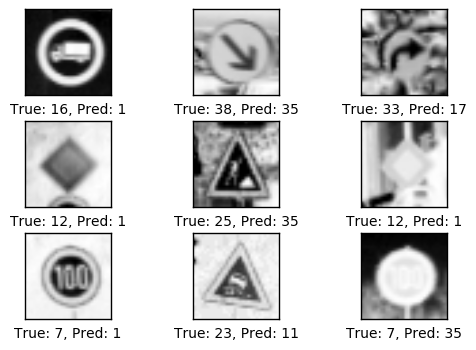

In [132]:
plot_example_errors()

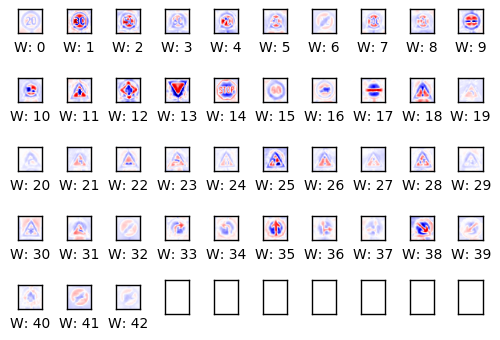

In [131]:
plot_weights()

[[  0  47   0 ...,   0   0   0]
 [  0 643   6 ...,   0   0   0]
 [  0 603  39 ...,   0   0   0]
 ..., 
 [  0  39   0 ...,   0   0   0]
 [  0  36   0 ...,   0  11   0]
 [  0  57   0 ...,   0   0   0]]


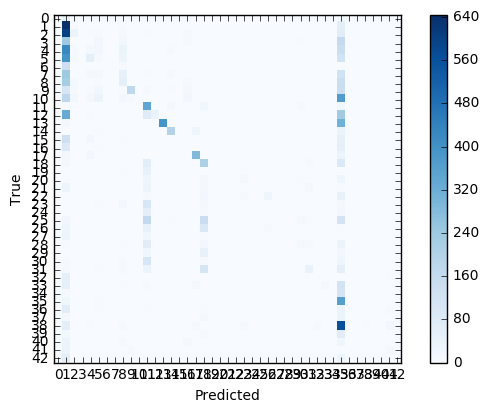

In [180]:
print_confusion_matrix()

## More iterations

In [181]:
optimize(num_iterations=1000)

Optimization Iteration:      1, Training Accuracy:  28.8%, Batch Cost: 3.1371774673461914
Optimization Iteration:    101, Training Accuracy:  32.3%, Batch Cost: 2.455112934112549
Optimization Iteration:    201, Training Accuracy:  51.9%, Batch Cost: 2.1069107055664062
Optimization Iteration:    301, Training Accuracy:  56.8%, Batch Cost: 1.8887983560562134
Optimization Iteration:    401, Training Accuracy:  57.4%, Batch Cost: 1.6280170679092407
Optimization Iteration:    501, Training Accuracy:  66.6%, Batch Cost: 1.4819083213806152
Optimization Iteration:    601, Training Accuracy:  69.8%, Batch Cost: 1.4179495573043823
Optimization Iteration:    701, Training Accuracy:  71.8%, Batch Cost: 1.385273814201355
Optimization Iteration:    801, Training Accuracy:  74.1%, Batch Cost: 1.3238584995269775
Optimization Iteration:    901, Training Accuracy:  75.1%, Batch Cost: 1.3361866474151611


In [182]:
print_accuracy()

Accuracy on test-set: 63.4%


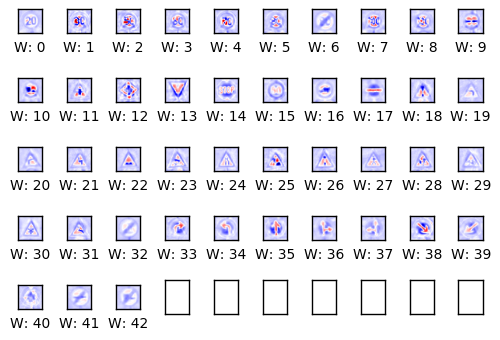

In [183]:
plot_weights()

[[  0  42   2 ...,   0   0   0]
 [  0 634  34 ...,   0   0   0]
 [  1  79 523 ...,   0   0   0]
 ..., 
 [  1  18   1 ...,  23   0   0]
 [  0   0   0 ...,   0  30   0]
 [  0   4   1 ...,   0  10   3]]


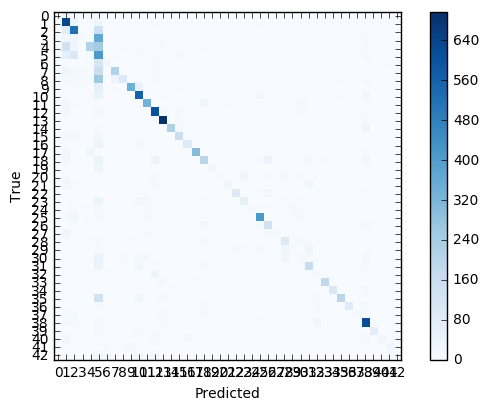

In [184]:
print_confusion_matrix()

In [185]:
optimize(num_iterations=10000)
print_accuracy()

Optimization Iteration:      1, Training Accuracy:  73.8%, Batch Cost: 1.1822247505187988
Optimization Iteration:    101, Training Accuracy:  71.3%, Batch Cost: 1.2151453495025635
Optimization Iteration:    201, Training Accuracy:  72.4%, Batch Cost: 1.3291981220245361
Optimization Iteration:    301, Training Accuracy:  78.3%, Batch Cost: 1.0552005767822266
Optimization Iteration:    401, Training Accuracy:  72.7%, Batch Cost: 1.1129045486450195
Optimization Iteration:    501, Training Accuracy:  77.4%, Batch Cost: 1.1010627746582031
Optimization Iteration:    601, Training Accuracy:  80.0%, Batch Cost: 1.0627907514572144
Optimization Iteration:    701, Training Accuracy:  80.3%, Batch Cost: 1.032609462738037
Optimization Iteration:    801, Training Accuracy:  82.4%, Batch Cost: 0.9399634599685669
Optimization Iteration:    901, Training Accuracy:  80.3%, Batch Cost: 0.9574815034866333
Optimization Iteration:   1001, Training Accuracy:  80.6%, Batch Cost: 0.9476538896560669
Optimizatio

[[ 13  21   0 ...,   0   0   0]
 [  0 641  24 ...,   0   0   0]
 [  2  43 629 ...,   1   0   0]
 ..., 
 [  0   1   2 ...,  42   0   0]
 [  0   0   0 ...,   0  39   0]
 [  0   0   1 ...,   0   3  64]]


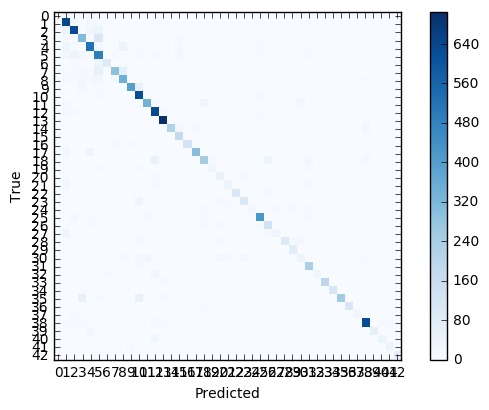

In [186]:
print_confusion_matrix()

In [187]:
optimize(num_iterations=1000)
print_accuracy()

Optimization Iteration:      1, Training Accuracy:  89.9%, Batch Cost: 0.5095019340515137
Optimization Iteration:    101, Training Accuracy:  90.2%, Batch Cost: 0.5512890815734863
Optimization Iteration:    201, Training Accuracy:  90.9%, Batch Cost: 0.5597001314163208
Optimization Iteration:    301, Training Accuracy:  91.5%, Batch Cost: 0.48107266426086426
Optimization Iteration:    401, Training Accuracy:  91.4%, Batch Cost: 0.4741899073123932
Optimization Iteration:    501, Training Accuracy:  92.0%, Batch Cost: 0.46724367141723633
Optimization Iteration:    601, Training Accuracy:  90.9%, Batch Cost: 0.48109275102615356
Optimization Iteration:    701, Training Accuracy:  92.0%, Batch Cost: 0.4757821559906006
Optimization Iteration:    801, Training Accuracy:  91.2%, Batch Cost: 0.46385684609413147
Optimization Iteration:    901, Training Accuracy:  91.4%, Batch Cost: 0.4876840114593506
Accuracy on test-set: 79.2%


In [43]:
optimize(num_iterations=1000)
print_accuracy()

Accuracy on test-set: 81.8%


In [44]:
optimize(num_iterations=1000)
print_accuracy()

Accuracy on test-set: 81.6%
